# Previsão de churn (abandono) em telecom

### Referências:
- https://github.com/RomeroBarata/IF702-redes-neurais

### Grupo 8:
- Erbert Gadelha (ebgr)
- João Pedro (jpba)
- Vinicius Barbosa (vrb)
- Almir Alves (aasc)
- Felipe Mateus (fmfb)

# Preparação e importação da base de dados

In [1]:
import kagglehub
import numpy as np
import numpy.typing as npt
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from scipy.stats import ks_2samp
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, mean_squared_error

tf.random.set_seed(42)
np.random.seed(42)

In [2]:
#@title Download data and create DataFrame
churn_data_path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", churn_data_path)

churn_df = pd.read_csv(churn_data_path + "/customer_churn_telecom_services.csv")
print(f"Data shape {churn_df.shape}")
churn_df.head()

Path to dataset files: /kaggle/input/customers-churned-in-telecom-services
Data shape (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploração dos dados

### Descrição das colunas:

| Column Name | Description |
|-------------|-------------|
| gender | Customer's gender (Male/Female) |
| SeniorCitizen |	Indicates if the customer is a senior citizen (1 = Yes, 0 = No) |
| Partner | Whether the customer has a partner (Yes/No) |
| Dependents | Whether the customer has dependents (Yes/No) |
|tenure |	Number of months the customer has stayed with the company |
|PhoneService |	Whether the customer has a phone service (Yes/No) |
|MultipleLines | Whether the customer has multiple phone lines (No, Yes, No phone service) |
|InternetService | Type of internet service (DSL, Fiber optic, No) |
|OnlineSecurity |	Whether the customer has online security (Yes, No, No internet service) |
|OnlineBackup |	Whether the customer has online backup (Yes, No, No internet service) |
|DeviceProtection |	Whether the customer has device protection (Yes, No, No internet service) |
|TechSupport | Whether the customer has tech support (Yes, No, No internet service) |
|StreamingTV | Whether the customer has streaming TV (Yes, No, No internet service) |
|StreamingMovies |	Whether the customer has streaming movies (Yes, No, No internet service) |
|Contract |	Type of contract (Month-to-month, One year, Two year) |
|PaperlessBilling |	Whether the customer has paperless billing (Yes/No) |
|PaymentMethod | Payment method used (Electronic check, Mailed check, Bank transfer, Credit card) |
|MonthlyCharges |	Monthly charges the customer pays |
|TotalCharges |	Total amount charged to the customer |
|Churn |	Whether the customer has churned (Yes/No) |

## Verificando valores nulos

In [3]:
#@title Verificando o dataset
churn_df.info()
nulls = churn_df['TotalCharges'].isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


A colunas `TotalCharges` possui 11 valores nulos, portanto essas amostras serão removidas.

In [4]:
#@title Removendo valores nulos
print(f"Data shape (before cleaning) {churn_df.shape}")
churn_df = churn_df.dropna()
print(f"Data shape (after cleaning) {churn_df.shape}")

Data shape (before cleaning) (7043, 20)
Data shape (after cleaning) (7032, 20)


## Verificando outliers

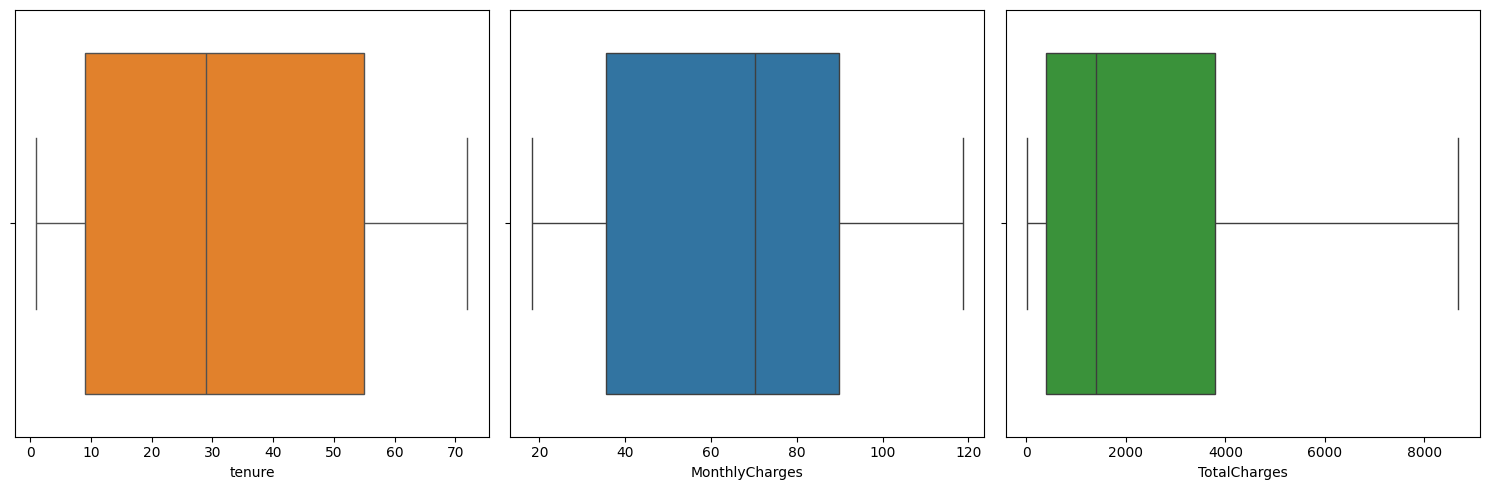

In [5]:
#@title Verificando a existência de outliers

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
colors = ['tab:orange', 'tab:blue', 'tab:green']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.boxplot(churn_df, x=feature, ax=axes[i], color=colors[i])
plt.tight_layout()

## Analisando distribuições

### Features Contínuas

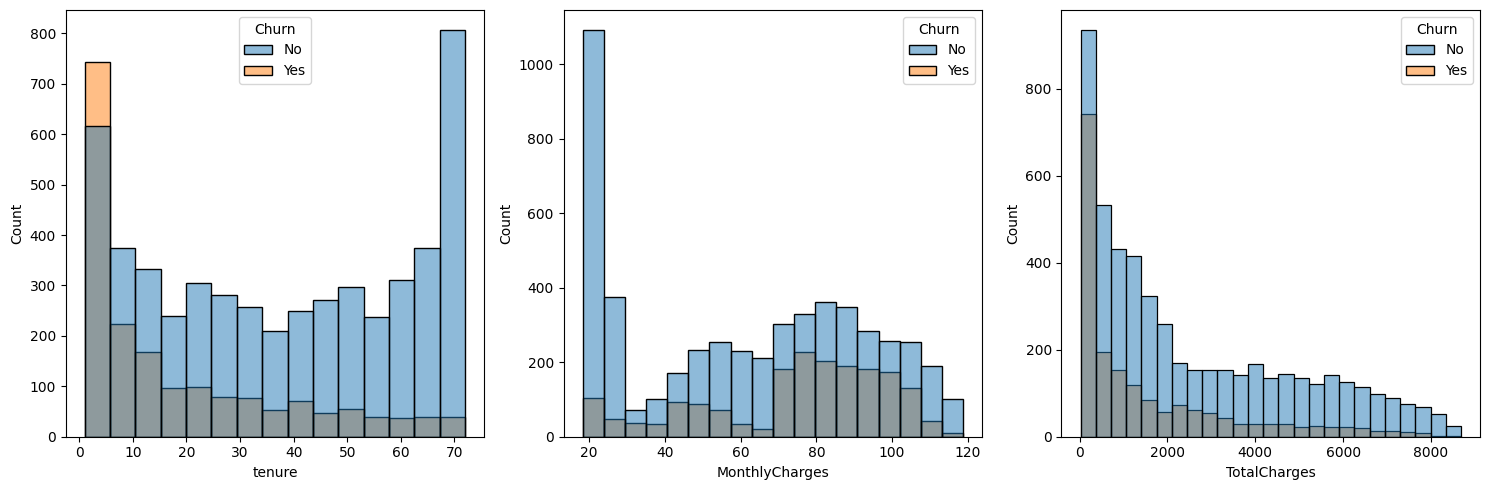

In [6]:
#@title Histograma por abandono

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(numerical_features):
  sns.histplot(churn_df, x=feature, ax=axes[i], hue='Churn')
plt.tight_layout()
plt.show()

A partir das distribuições podemos deduzir os seguintes pontos:
*   Clientes jovens tendem a abandonar mais, enquanto pessoas com mais idade tendem a continuar sendo clientes
*   Cobranças mensais muito baixas contribuem para uma alta taxa de fidelidade, mas valores mais altos não apresentam uma influência notável



# Preparação dos dados

In [7]:
#@title Convertendo tipos categóricos

cat_df = churn_df.select_dtypes(include=['object', 'category'])
for col in cat_df.columns:
  churn_df[col] = churn_df[col].astype('category')
  churn_df[col] = churn_df[col].cat.codes

  if col == 'Churn':
    continue

  # one hot encode if more than 2 alternatives
  if len(churn_df[col].unique()) > 2:
    churn_df = pd.concat([churn_df, pd.get_dummies(churn_df[col], prefix=col)], axis=1)
    churn_df = churn_df.drop(columns=[col])

churn_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 41 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   gender              7032 non-null   int8   
 1   SeniorCitizen       7032 non-null   int64  
 2   Partner             7032 non-null   int8   
 3   Dependents          7032 non-null   int8   
 4   tenure              7032 non-null   int64  
 5   PhoneService        7032 non-null   int8   
 6   PaperlessBilling    7032 non-null   int8   
 7   MonthlyCharges      7032 non-null   float64
 8   TotalCharges        7032 non-null   float64
 9   Churn               7032 non-null   int8   
 10  MultipleLines_0     7032 non-null   bool   
 11  MultipleLines_1     7032 non-null   bool   
 12  MultipleLines_2     7032 non-null   bool   
 13  InternetService_0   7032 non-null   bool   
 14  InternetService_1   7032 non-null   bool   
 15  InternetService_2   7032 non-null   bool   
 16  OnlineSecur

In [8]:
#@title Divisão estratificada Treino / Validação / Teste (50% / 25% / 25%)
X = churn_df.drop(columns=['Churn'])
y = churn_df['Churn']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_train)

print(f"Train shape {X_train.shape}")
print(f"Validation shape {X_val.shape}")
print(f"Test shape {X_test.shape}")

Train shape (3516, 40)
Validation shape (1758, 40)
Test shape (1758, 40)


In [9]:
#@title Normalização das features numéricas

mean_train = X_train.mean()
std_train = X_train.std()

X_train_n = X_train.copy(deep=True)
X_val_n = X_val.copy(deep=True)
X_test_n = X_test.copy(deep=True)

for col in numerical_features:
  X_train_n[col] = (X_train[col] - mean_train[col]) / std_train[col]
  X_val_n[col] = (X_val[col] - mean_train[col]) / std_train[col]
  X_test_n[col] = (X_test[col] - mean_train[col]) / std_train[col]

print("===========================================================================")
print("Distribuições do conjunto de treino")
print("===========================================================================")
print(X_train.describe())
print("===========================================================================")
print("Distribuições (normalizadas) do conjunto de treino")
print("===========================================================================")
print(X_train_n.describe())

Distribuições do conjunto de treino
            gender  SeniorCitizen      Partner   Dependents       tenure  \
count  3516.000000    3516.000000  3516.000000  3516.000000  3516.000000   
mean      0.503982       0.165529     0.483788     0.300910    32.577361   
std       0.500055       0.371710     0.499808     0.458719    24.400907   
min       0.000000       0.000000     0.000000     0.000000     1.000000   
25%       0.000000       0.000000     0.000000     0.000000     9.000000   
50%       1.000000       0.000000     0.000000     0.000000    29.000000   
75%       1.000000       0.000000     1.000000     1.000000    55.000000   
max       1.000000       1.000000     1.000000     1.000000    72.000000   

       PhoneService  PaperlessBilling  MonthlyCharges  TotalCharges  
count   3516.000000       3516.000000     3516.000000   3516.000000  
mean       0.905575          0.593572       65.079238   2304.446217  
std        0.292461          0.491236       30.200006   2264.169199  

# Métodos auxiliares

In [10]:
#@title Cálculo do Teste Kolmogorov-Smirnov

def calc_ks(y_true: npt.NDArray, y_pred: npt.NDArray):
  return ks_2samp(y_pred[y_true == 0], y_pred[y_true == 1])

In [11]:
#@title Plot da Matriz de Confusão

def plot_conf_matrix(cm):
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [12]:
#@title Plot da curva ROC

def plot_roc(fpr, tpr, auc, label):
  plt.figure(figsize=(6, 6))
  plt.plot(fpr, tpr, label=f'{label} (AUC = {auc:.2f})')
  plt.plot([0, 1], [0, 1], '--', color='tab:orange')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc="lower right")
  plt.show()

# Execução inicial com classificadores

In [13]:
#@title Parâmetros gerais
epochs = 10000
patience = 20

## MLP

In [14]:
#@title Definição do modelo
mlp_classifier = Sequential()
mlp_classifier.add(Input(shape=(X_train.shape[1],)))
mlp_classifier.add(Dense(10, activation='relu'))
mlp_classifier.add(Dense(1, activation='sigmoid'))
mlp_classifier.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
mlp_classifier.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 10)             │           410 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421 (1.64 KB)

 Trainable params: 421 (1.64 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#@title Treinamento inicial
mlp_history = mlp_classifier.fit(X_train_n, y_train, epochs=epochs, validation_data=(X_val_n, y_val),
                                 callbacks=[EarlyStopping(patience=patience, monitor='val_loss')])

Epoch 1/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.2841 - val_loss: 0.1541
Epoch 2/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1430 - val_loss: 0.1457
Epoch 3/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1361 - val_loss: 0.1420
Epoch 4/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1331 - val_loss: 0.1401
Epoch 5/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1319 - val_loss: 0.1389
Epoch 6/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1313 - val_loss: 0.1382
Epoch 7/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1308 - val_loss: 0.1378
Epoch 8/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1305 - val_loss: 0.1375
Epoch 9/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1302 - val_loss: 0.1373
Epoch 10/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1300 - val_loss: 0.1372
Epoch 11/10000
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1298 - val_loss: 0.1370
Epoch 12/10000
110

### Avaliação inicial

In [16]:
#@title Gerando predições
mlp_preds = mlp_classifier.predict(X_test_n)

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [17]:
#@title Teste Kolmogorov-Smirnov
mlp_ks = calc_ks(y_test, mlp_preds)
print(f"Teste Kolmogorov-Smirnov: {mlp_ks.statistic[0]} (p-value: {mlp_ks.pvalue[0]})")

Teste Kolmogorov-Smirnov: 0.506145738954325 (p-value: 1.7387460646009414e-80)


In [18]:
#@title MSE
mlp_mse = mlp_classifier.evaluate(X_test_n, y_test, verbose=0)
print(f"MSE: {mlp_mse}")

MSE: 0.14112618565559387


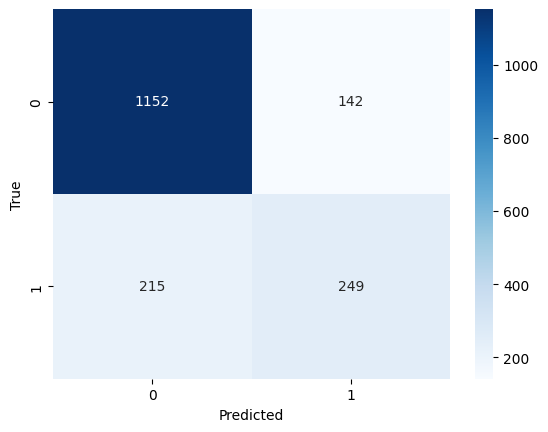

In [19]:
#@title Matriz de confusão
mlp_cm = confusion_matrix(y_test, np.round(mlp_preds))
plot_conf_matrix(mlp_cm)

AUC-ROC: 0.8289086233544741


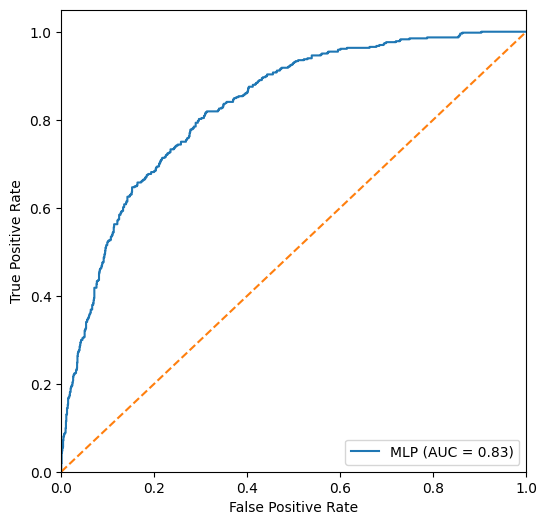

In [20]:
#@title AUC-ROC
mlp_auc = roc_auc_score(y_test, mlp_preds)
print(f"AUC-ROC: {mlp_auc}")
mlp_fpr, mlp_tpr, _ = roc_curve(y_test, mlp_preds)
plot_roc(mlp_fpr, mlp_tpr, mlp_auc, 'MLP')

In [21]:
#@title Recall, precision e f-score
mlp_recall = recall_score(y_test, np.round(mlp_preds))
mlp_precision = precision_score(y_test, np.round(mlp_preds))
mlp_f1 = f1_score(y_test, np.round(mlp_preds))
print(f"Recall: {mlp_recall}")
print(f"Precision: {mlp_precision}")
print(f"F1-score: {mlp_f1}")

Recall: 0.5366379310344828
Precision: 0.6368286445012787
F1-score: 0.5824561403508772


## Random Forest

In [22]:
#@title Definição do modelo
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier

RandomForestClassifier(random_state=42)

In [23]:
#@title Treinamento inicial
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

### Avaliação inicial

In [24]:
#@title Gerando predições
rf_preds = rf_classifier.predict(X_test)
print(f"Predições: {rf_preds.shape}")

Predições: (1758,)


In [25]:
#@title Teste Kolmogorov-Smirnov
rf_ks = calc_ks(y_test, rf_preds)
print(f"Teste Kolmogorov-Smirnov: {rf_ks.statistic} (p-value: {rf_ks.pvalue})")

Teste Kolmogorov-Smirnov: 0.34191294036134945 (p-value: 5.717513136643597e-36)


In [26]:
#@title MSE
rf_mse = mean_squared_error(y_test, rf_preds)
print(f"MSE: {rf_mse}")

MSE: 0.22696245733788395


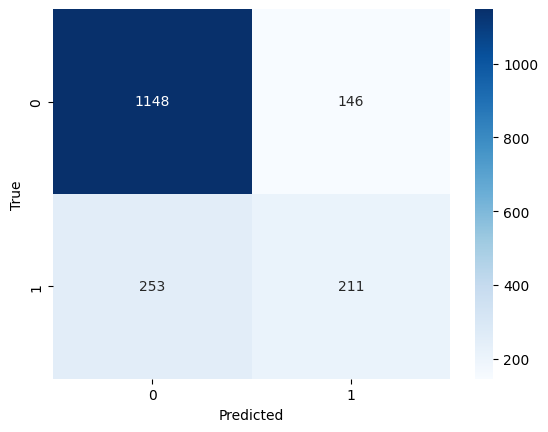

In [27]:
#@title Matriz de confusão
rf_cm = confusion_matrix(y_test, rf_preds)
plot_conf_matrix(rf_cm)

AUC-ROC: 0.6709564701806747


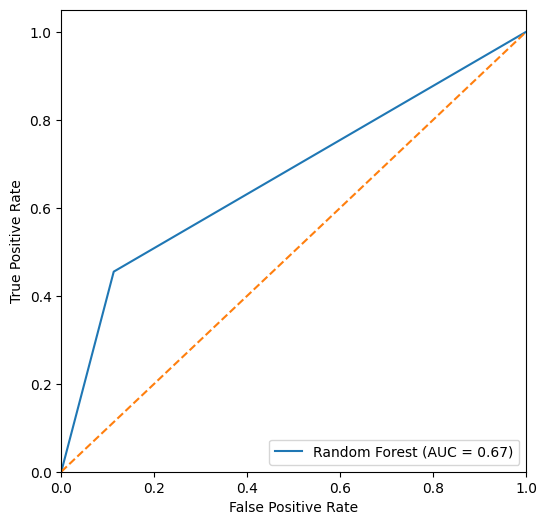

In [28]:
#@title AUC-ROC
rf_auc = roc_auc_score(y_test, rf_preds)
print(f"AUC-ROC: {rf_auc}")
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_preds)
plot_roc(rf_fpr, rf_tpr, rf_auc, 'Random Forest')

In [29]:
#@title Recall, precision e f-score
rf_recall = recall_score(y_test, rf_preds)
rf_precision = precision_score(y_test, rf_preds)
rf_f1 = f1_score(y_test, rf_preds)
print(f"Recall: {rf_recall}")
print(f"Precision: {rf_precision}")
print(f"F1-score: {rf_f1}")

Recall: 0.4547413793103448
Precision: 0.5910364145658263
F1-score: 0.5140073081607796


# Otimizando classificadores iniciais

## MLP

## Random Forest

# Executando mais classificadores

## STab

In [30]:
#@title Treinamento inicial

### Avaliação inicial

In [31]:
#@title Teste Kolmogorov-Smirnov

In [32]:
#@title (MSE ou Entropia Cruzada)

In [33]:
#@title Matriz de confusão

In [34]:
#@title AUC-ROC

In [35]:
#@title Recall, precision e f-score

## TabPFN2 Transformer

In [36]:
#@title Treinamento inicial

### Avaliação inicial

In [37]:
#@title Teste Kolmogorov-Smirnov

In [38]:
#@title (MSE ou Entropia Cruzada)

In [39]:
#@title Matriz de confusão

In [40]:
#@title AUC-ROC

In [41]:
#@title Recall, precision e f-score

## Gradient Boosting

In [42]:
#@title Treinamento inicial

### Avaliação inicial

In [43]:
#@title Teste Kolmogorov-Smirnov

In [44]:
#@title (MSE ou Entropia Cruzada)

In [45]:
#@title Matriz de confusão

In [46]:
#@title AUC-ROC

In [47]:
#@title Recall, precision e f-score

# Avaliação final

## Comparação de métricas de todos os modelos